In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/Stock-Prediction/'
!ls /content/drive/MyDrive/Stock-Prediction

AAPL.csv  AMZN.csv  Daily_data_AAPL.csv  GOOG.csv  GOOG-year.csv


In [3]:
import numpy as np
import pandas as pd
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
df = pd.read_csv(path+'AAPL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-23,68.967499,70.437500,68.717499,68.757500,68.228622,124814400
1,2020-04-24,69.300003,70.752502,69.250000,70.742500,70.198349,126508800
2,2020-04-27,70.449997,71.135002,69.987503,70.792503,70.247971,117087600
3,2020-04-28,71.269997,71.457497,69.550003,69.644997,69.109299,112004800
4,2020-04-29,71.182503,72.417503,70.972504,71.932503,71.379196,137280800


In [5]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [6]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 5, initial_money = initial_money)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch: 5, total rewards: -11.609987.3, cost: -19380.375000, total money: 9988.390013
epoch: 10, total rewards: -11.847475.3, cost: -20671.763672, total money: 9988.152525
epoch: 15, total rewards: -16.077479.3, cost: -21891.503906, total money: 9983.922521
epoch: 20, total rewards: -5.944980.3, cost: -23001.777344, total money: 9994.055020
epoch: 25, total rewards: 3.657513.3, cost: -23960.378906, total money: 10003.657513
epoch: 30, total rewards: -1.854986.3, cost: -24700.257812, total money: 9998.145014
epoch: 35, total rewards: 1.180017.3, cost: -25258.412109, total money: 10001.180017
epoch: 40, total rewards: -16.120018.3, cost: -25791.234375, total money: 9983.879982
epoch: 45, total rewards: 27.984979.3, cost: -26162.019531, total money: 10027.984979
epoch: 50, total rewards: 100.534957.3, cost: -26506.720703, total money: 10100.534957
epoch: 55, total rewards: 57.077467.3, cost: -26948.230469, total money: 10057.077467
epoch: 60, total rewards: 117.634948.3, cost: -27276.10351

In [7]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 68.757500, total balance 9931.242500
day 1: buy 1 unit at price 70.742500, total balance 9860.500000
day 5, sell 1 unit at price 73.449997, investment 6.824706 %, total balance 9933.949997,
day 6, sell 1 unit at price 72.267502, investment 2.155708 %, total balance 10006.217499,
day 7: buy 1 unit at price 73.290001, total balance 9932.927498
day 8: buy 1 unit at price 74.389999, total balance 9858.537499
day 10, sell 1 unit at price 75.934998, investment 3.608947 %, total balance 9934.472497,
day 13: buy 1 unit at price 77.852501, total balance 9856.619996
day 14: buy 1 unit at price 76.912498, total balance 9779.707498
day 15: buy 1 unit at price 77.385002, total balance 9702.322496
day 18: buy 1 unit at price 78.285004, total balance 9624.037492
day 19: buy 1 unit at price 79.807503, total balance 9544.229989
day 20, sell 1 unit at price 79.212502, investment 6.482730 %, total balance 9623.442491,
day 21: buy 1 unit at price 79.722504, total balance 9543.71

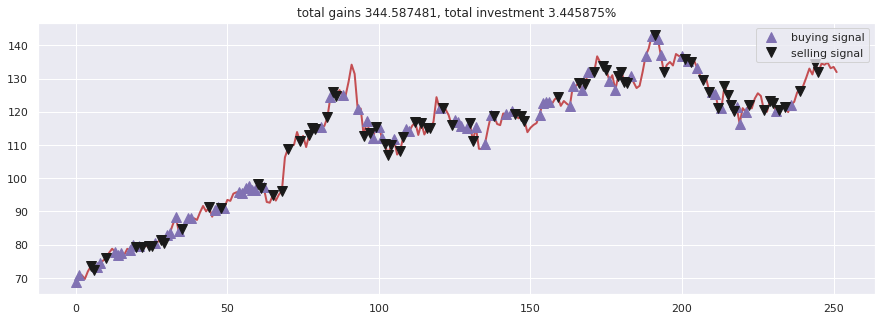

In [8]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()